In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys
import seaborn as sns

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

# GM

In [3]:
#you can also query like this
blaze_gm_data = pd.read_sql_query("""
with base as 
(
   select
      *,
      last_day(week_start) year_month,
      retail_value / quantity_sold per_unit_price,
      cogs / quantity_sold per_unit_cost,
      sales.retail_value - sales.total_discount + sales.total_tax sales_post_tax_post_discount,
      sales.retail_value - sales.total_discount sales_pre_tax_post_discount,
      sales.retail_value sales_pre_tax_pre_discount,
   from
      blaze_data.sales sales
      -- EXCLUDE SAMPLES,DISPLAY,PROMO and test
   where
      lower(product_category) not like '%sample%' 
      and lower(product_category) not like '%display%' 
      and lower(product_category) not like '%promo%' 
      and lower(product_category) not like '%test%'
      and state = 'CA'
)
,
monthly_location_rev_and_cogs as 
(
   select
      year_month,
      shop_id shopid,
      company_id companyid,
      sum(sales_post_tax_post_discount) rev_post_tax_post_discount,
      sum(sales_pre_tax_post_discount) rev_pre_tax_post_discount,
      sum(sales_pre_tax_pre_discount) rev_pre_tax_pre_discount,
      sum(cogs) cogs 
   from
      base
      -- EXCLUDE low COGS items
   where
      cogs > 1 
      -- EXCLUDE high cost, high price items
      and per_unit_price <= 500 
      and per_unit_cost <= 500 
   group by
      2,
      3,
      1 
   order by
      2,
      3,
      1 
)
,
monthly_location_rev_and_cogs_and_profit as 
(
   select
      year_month,
      shopid,
      companyid,
      -- rev and cogs
      rev_post_tax_post_discount,
      rev_pre_tax_post_discount,
      rev_pre_tax_pre_discount,
      cogs,
      -- profit
      rev_post_tax_post_discount - cogs profit_post_tax_post_discount,
      rev_pre_tax_post_discount - cogs profit_pre_tax_post_discount,
      rev_pre_tax_pre_discount - cogs profit_pre_tax_pre_discount,
   from
      monthly_location_rev_and_cogs 
)
,
monthly_location_rev_and_cogs_and_profit_and_margin as 
(
   select
      year_month,
      shopid,
      companyid,
      -- rev and cogs
      rev_post_tax_post_discount,
      rev_pre_tax_post_discount,
      rev_pre_tax_pre_discount,
      cogs,
      -- profit
      profit_post_tax_post_discount,
      profit_pre_tax_post_discount,
      profit_pre_tax_pre_discount,
      -- margin
      profit_post_tax_post_discount / nullif(rev_post_tax_post_discount, 0) margin_post_tax_post_discount,
      profit_pre_tax_post_discount / nullif(rev_pre_tax_post_discount, 0) margin_pre_tax_post_discount,
      profit_pre_tax_pre_discount / nullif(rev_pre_tax_pre_discount, 0) margin_pre_tax_pre_discount 
   from
      monthly_location_rev_and_cogs_and_profit 
)
,
monthly_gm_analysis as 
(
   select
      year_month,
      shopid,
      companyid,
      -- CHOOSE TO USE PRE TAX POST DISCOUNT
      rev_pre_tax_post_discount,
      lag(rev_pre_tax_post_discount) over (partition by shopid order by year_month) lag_rev_pre_tax_post_discount,
      cogs,
      profit_pre_tax_post_discount,
      margin_pre_tax_post_discount,
      count(distinct year_month) over (partition by shopid ) month_available,
      sum(cogs) over (partition by shopid order by year_month rows between 2 preceding and current row ) sum_cogs_3m,
      avg(margin_pre_tax_post_discount) over (partition by shopid order by year_month rows between 2 preceding and current row ) avg_margin_3m,
      avg(margin_pre_tax_post_discount) over (partition by shopid order by year_month rows between 5 preceding and current row ) avg_margin_6m,
      avg(margin_pre_tax_post_discount) over (partition by shopid order by year_month ) avg_margin_all 
   from
      monthly_location_rev_and_cogs_and_profit_and_margin 
)
select
   *,
   (
      rev_pre_tax_post_discount - lag_rev_pre_tax_post_discount
   )
   / nullif(lag_rev_pre_tax_post_discount, 0) rev_change 
from
   monthly_gm_analysis
   where shopid not in ("5e50449d6c0a910843356fa3",
                        "5e666af1aa809b085a98a646",
                        "56cf846ee38179985229e59e",
                        "5e6d0948b987950831b5092c",
                        "5ab806d6c182bb072e0b0e01",
                        "617b7da0e5cb65322b32781a",
                        "56cf84e4e38179985229e59f",
                        "5ee7c6a938fa9a08c8b7939c",
                        "5eebecd661ea0b08cdbcc386",
                        "56cf855ce38179985229e5a0",
                        "5ef12ad7bb5e7a08c5b3f4f3",
                        "5f1108355ae12008f4fef76e",
                        "5f123a5d12497908d2888dde",
                        "5f2309d579373608c93e6742",
                        "5f341ed02fdd5608e0821b45",
                        "5f8870200260fe08fe708db5",
                        "5f8870200260fe08fe708db6",
                        "5fac6a0b0643cc08efd1d327",
                        "56cf855ce38179985229e5a1",
                        "5d238c1955be2e07f5ee66e5",
                        "57b35a5d920f401e40146301",
                        "603d1a9eb9d7dc08cca27203",
                        "603d1a9eb9d7dc08cca27204",
                        "6046544f61e17808cff96fdb",
                        "6046544f61e17808cff96fdc",
                        "57b35aa8920f401e40146334",
                        "57b6b145920f4045cbe5fe81",
                        "6059219abe32aa08fa3a11dc",
                        "57b6b36a920f4046337f2618",
                        "58a7433f819d9e6ebd427617",
                        "60c0ffd6331cab296f02f49a",
                        "610c0a0d381ba0747c981ce9",
                        "611c0c98127cdd740cff94db",
                        "5a43f72b819d9e3ef9373675",
                        "611c0cc403d2e97dc2c159b0",
                        "5e6d0ac5b987950831b513e3",
                        "5a4563f1819d9e4ae6207e06",
                        "611c0ce7649819050ed4906b",
                        "611c0d02f572ec7882d64eea",
                        "611c0d26d5f1e86542fe3b8b",
                        "61672305b5e382719c7e4c2a",
                        "616dee0e4497e822dae13b21",
                        "616e5b13dd10fe4d3f34fd05",
                        "616e5b13dd10fe4d3f34fd06",
                        "619834e921c8017e23135674",
                        "5ab2d1a5819d9e21137cec3c",
                        "61bb746b82fddc50e058d711",
                        "61c3be757511d81170a29d51",
                        "61d49080eec1b51a3e33dc39",
                        "61d8912bdd71d40c2b68c5b3",
                        "61ba4efb9536472be6a8baa9",
                        "61d895fb3efbfb6da5210ae3",
                        "61d8aaf527205210191d7a1e",
                        "61e72d51073c4a79cfeccb62",
                        "61fdab9eae59d05c49422c3a",
                        "6202bd1c15425361f688aabf",
                        "6202bd1c15425361f688aac0",
                        "5b9f8e1db93307080d35b85f",
                        "5c2c250eabe12808989ac2f7",
                        "58be5603c182bb1f9bcd2ad5",
                        "5c8be64665a6a40808118621",
                        "606761051436a608e166db19",
                        "5ce2eb562d4dcf07fb7d0c5f",
                        "6176fa9eda707b1faba5f717",
                        "5b517867485da70830fcc04e",
                        "5b9f841a17b6e00812fe71f3",
                        "5da023586d8ce1082b9c91bd",
                        "5bbce3db420c21083300e410",
                        "5d238c1955be2e07f5ee66e4",
                        "5b209459062bd807b142a1f6",
                        "5cb1a5839fbb5f0818f6de55",
                        "5cda1adb183d6a0801347027",
                        "5be3903b79015e083194aa70",
                        "5d1ba174cdbd6d0803c99cfd",
                        "5a8a6eb8819d9e78641ab6ec",
                        "5db863825a04a2083b464083",
                        "5d8a7fb3a3274308311743d5",
                        "5d8a7fb3a3274308311743d6",
                        "5d9e425d52d15b0824a8a5d5",
                        "5dd6da52ce4015084c72e8db",
                        "5e07f51837cdd7082662f3c6",
                        "5e4d849981e3cd08326b6c14",
                        "5dfd2308fa462a086a8bfab8",
                        "5e0ee2710a7b7008346b06b4",
                        "5e4d849981e3cd08326b6c15",
                        "5dfd2308fa462a086a8bfab9",
                        "5e6d0adc12f2e208728f9369",
                        "5e6d0948b987950831b5092b",
                        "5ed589d96c0bf408dcc92d97",
                        "5eebecd761ea0b08cdbcc387",
                        "5ef12ad7bb5e7a08c5b3f4f2",
                        "5f63afd430bd7208ce1ab304",
                        "5f63afd430bd7208ce1ab305",
                        "5bf5ce54062bd807e436b473",
                        "5fac691a715f3808cd0aa82d",
                        "5d9d7fc27e2e46081e7e69f3",
                        "6034287d52503608c0b3ca48",
                        "5dfd40ea521ea90860c91848",
                        "6034287d52503608c0b3ca49",
                        "60636227ec491108d1c970d5",
                        "5a9a2274c182bb4ec00a72ca",
                        "60aea3bb1940943cecec2dbf",
                        "60a2f1610f75543c8e7dde50",
                        "5eb98f2d649a6508f87a6436",
                        "5e62a68447d90a086b8231c0",
                        "5e62a68447d90a086b8231c1",
                        "615b634cac08aa0a794158c4",
                        "60a2db8d0f75543c8e7d513b",
                        "60a2db8d0f75543c8e7d513c",
                        "60a4051e67406e7edad8ab88",
                        "60c0ff66082dcc61e42ad4a6",
                        "60c0ff66082dcc61e42ad4a7",
                        "6046c57057abe808d1f260fd",
                        "60636227ec491108d1c970d4",
                        "610abcaec3d09859f9b630d1",
                        "606cfaadba253e08c4189a63",
                        "607a321441cfa308f6e65b58",
                        "6197e31b21c8017e2310c10e",
                        "611d457db7c6f80914292394",
                        "610c0a0d381ba0747c981cea",
                        "610abcaec3d09859f9b630d2",
                        "611c0cb3a29e0f598f108a60",
                        "5fff453a81a63608d3a1a5b7",
                        "615237cc0937e52684b6c134",
                        "620b59c97852ca7a7dcc6f05",
                        "6196aa4deb62c87eba4014ad",
                        "619816781f88a1280f8a0c28",
                        "61d7b217a42c2f124d9b76b1",
                        "61cf4b452bc6657512b92d2a",
                        "61ebb060b04dc7510465f774",
                        "61eedaa0b882812f2f46a23d",
                        "61eedade6716dd2a2e0cfce5",
                        "5e6d0ae6e4a25a0834047467",
                        "5dc3315fe0faca07c6dfe849",
                        "5f7e17594445b008d2f63ebd",
                        "5f7f63053dbcad08cc9edbfb",
                        "5fff453a81a63608d3a1a5b8",
                        "603d5425a9ca7208f886d156",
                        "60e48dbbd5596d7c8a1d24dc",
                        "611c0d335901162ff90ef4dd",
                        "613f771aa96c863c00c1517d",
                        "6153b70fd343dc6230c4b67d",
                        "61699cdf032e1c1f920ec70f",
                        "61699cdf032e1c1f920ec710",
                        "61a7b4c6c8c7d85ea1846f14",
                        "61c390cfb863cb3baddb70f4",
                        "61d7b252ae999342ac05499e",
                        "61e6f857c5da34762f1c1fb5",
                        "61ebb00a335a531542342a32",
                        "620b59c97852ca7a7dcc6f04",
                        "6226640755810d3311e8ecd0")
""",engine)

In [4]:
blaze_gm_data['year_month'] = pd.to_datetime(blaze_gm_data['year_month'])

In [5]:
blaze_gm_data['shopid'].nunique()

348

In [6]:
blaze_gm_data[['year_month','shopid']].groupby(['year_month']).nunique()

,shopid
year_month,
2021-08-31,234
2021-09-30,246
2021-10-31,258
2021-11-30,257
2021-12-31,267
2022-01-31,263
2022-02-28,264
2022-03-31,273
2022-04-30,268


In [7]:
blaze_gm_data_long = blaze_gm_data[blaze_gm_data['month_available'] >= 6]

In [8]:
blaze_gm_data_long[['year_month','shopid']].groupby(['year_month']).nunique()

,shopid
year_month,
2021-08-31,204
2021-09-30,214
2021-10-31,223
2021-11-30,237
2021-12-31,250
2022-01-31,259
2022-02-28,255
2022-03-31,253
2022-04-30,249


In [9]:
blaze_gm_data_long[blaze_gm_data_long['year_month'] == '2022-06-30'][['shopid','month_available']].groupby(['month_available']).nunique()



,shopid
month_available,
6,11
7,16
8,13
9,13
10,15
11,174


In [10]:
#canex
blaze_gm_data_long[blaze_gm_data_long['shopid'] == '5e7e382298b27008c4b1dd2c']

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change
1941,2021-08-31,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1115698.92,NaN,332295.58,783403.34,0.702164,11,332295.58,0.702164,0.702164,0.702164,NaN
1942,2021-09-30,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1388192.66,1115698.92,411934.97,976257.69,0.703258,11,744230.55,0.702711,0.702711,0.702711,0.244236
1943,2021-10-31,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1435250.95,1388192.66,429648.56,1005602.39,0.700646,11,1173879.11,0.702023,0.702023,0.702023,0.033899
1944,2021-11-30,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1294017.31,1435250.95,428172.10,865845.21,0.669114,11,1269755.63,0.691006,0.693795,0.693795,-0.098403
1945,2021-12-31,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1412869.84,1294017.31,444759.64,968110.20,0.685208,11,1302580.30,0.684989,0.692078,0.692078,0.091848
1946,2022-01-31,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1477630.58,1412869.84,467628.72,1010001.86,0.683528,11,1340560.46,0.679283,0.690653,0.690653,0.045836
1947,2022-02-28,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1226724.39,1477630.58,309976.69,916747.70,0.747314,11,1222365.05,0.705350,0.698178,0.698747,-0.169803
1948,2022-03-31,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1242103.26,1226724.39,331486.83,910616.43,0.733125,11,1109092.24,0.721322,0.703156,0.703045,0.012537
1949,2022-04-30,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,797513.08,1242103.26,334123.00,463390.08,0.581044,11,975586.52,0.687161,0.683222,0.689489,-0.357933
1950,2022-05-31,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,747521.39,797513.08,317676.75,429844.64,0.575027,11,983286.58,0.629732,0.667541,0.678043,-0.062684


# Rev change

In [11]:
def gmv_change_variance_point_mapping(x):
    if x < -0.1:
        return -5
    elif x >= -0.1 and x <-0.05:
        return -2.5
    elif x >= -0.05 and x < 0:
        return 0
    elif x >= 0 and x < 0.05:
        return 5
    elif x >= 0.05 and x <= 0.5:
        return 10
    else:
        return numpy.nan
    

In [12]:
#you can also query like this
blaze_ca_gmv_change_data = pd.read_sql_query("""
---------------------------------------------------------------------------------------------------------------------
with base as
(
   select
      shop_id,
      company_id,
      last_day(week_start) year_month,
      sales.retail_value - sales.total_discount sales_pre_tax_post_discount
   from
      blaze_data.sales sales

   where
      lower(product_category) not like '%sample%'
      and lower(product_category) not like '%display%'
      and lower(product_category) not like '%promo%'
      and lower(product_category) not like '%test%'
      and state = 'CA'
      and shop_id not in ("5e50449d6c0a910843356fa3",
                        "5e666af1aa809b085a98a646",
                        "56cf846ee38179985229e59e",
                        "5e6d0948b987950831b5092c",
                        "5ab806d6c182bb072e0b0e01",
                        "617b7da0e5cb65322b32781a",
                        "56cf84e4e38179985229e59f",
                        "5ee7c6a938fa9a08c8b7939c",
                        "5eebecd661ea0b08cdbcc386",
                        "56cf855ce38179985229e5a0",
                        "5ef12ad7bb5e7a08c5b3f4f3",
                        "5f1108355ae12008f4fef76e",
                        "5f123a5d12497908d2888dde",
                        "5f2309d579373608c93e6742",
                        "5f341ed02fdd5608e0821b45",
                        "5f8870200260fe08fe708db5",
                        "5f8870200260fe08fe708db6",
                        "5fac6a0b0643cc08efd1d327",
                        "56cf855ce38179985229e5a1",
                        "5d238c1955be2e07f5ee66e5",
                        "57b35a5d920f401e40146301",
                        "603d1a9eb9d7dc08cca27203",
                        "603d1a9eb9d7dc08cca27204",
                        "6046544f61e17808cff96fdb",
                        "6046544f61e17808cff96fdc",
                        "57b35aa8920f401e40146334",
                        "57b6b145920f4045cbe5fe81",
                        "6059219abe32aa08fa3a11dc",
                        "57b6b36a920f4046337f2618",
                        "58a7433f819d9e6ebd427617",
                        "60c0ffd6331cab296f02f49a",
                        "610c0a0d381ba0747c981ce9",
                        "611c0c98127cdd740cff94db",
                        "5a43f72b819d9e3ef9373675",
                        "611c0cc403d2e97dc2c159b0",
                        "5e6d0ac5b987950831b513e3",
                        "5a4563f1819d9e4ae6207e06",
                        "611c0ce7649819050ed4906b",
                        "611c0d02f572ec7882d64eea",
                        "611c0d26d5f1e86542fe3b8b",
                        "61672305b5e382719c7e4c2a",
                        "616dee0e4497e822dae13b21",
                        "616e5b13dd10fe4d3f34fd05",
                        "616e5b13dd10fe4d3f34fd06",
                        "619834e921c8017e23135674",
                        "5ab2d1a5819d9e21137cec3c",
                        "61bb746b82fddc50e058d711",
                        "61c3be757511d81170a29d51",
                        "61d49080eec1b51a3e33dc39",
                        "61d8912bdd71d40c2b68c5b3",
                        "61ba4efb9536472be6a8baa9",
                        "61d895fb3efbfb6da5210ae3",
                        "61d8aaf527205210191d7a1e",
                        "61e72d51073c4a79cfeccb62",
                        "61fdab9eae59d05c49422c3a",
                        "6202bd1c15425361f688aabf",
                        "6202bd1c15425361f688aac0",
                        "5b9f8e1db93307080d35b85f",
                        "5c2c250eabe12808989ac2f7",
                        "58be5603c182bb1f9bcd2ad5",
                        "5c8be64665a6a40808118621",
                        "606761051436a608e166db19",
                        "5ce2eb562d4dcf07fb7d0c5f",
                        "6176fa9eda707b1faba5f717",
                        "5b517867485da70830fcc04e",
                        "5b9f841a17b6e00812fe71f3",
                        "5da023586d8ce1082b9c91bd",
                        "5bbce3db420c21083300e410",
                        "5d238c1955be2e07f5ee66e4",
                        "5b209459062bd807b142a1f6",
                        "5cb1a5839fbb5f0818f6de55",
                        "5cda1adb183d6a0801347027",
                        "5be3903b79015e083194aa70",
                        "5d1ba174cdbd6d0803c99cfd",
                        "5a8a6eb8819d9e78641ab6ec",
                        "5db863825a04a2083b464083",
                        "5d8a7fb3a3274308311743d5",
                        "5d8a7fb3a3274308311743d6",
                        "5d9e425d52d15b0824a8a5d5",
                        "5dd6da52ce4015084c72e8db",
                        "5e07f51837cdd7082662f3c6",
                        "5e4d849981e3cd08326b6c14",
                        "5dfd2308fa462a086a8bfab8",
                        "5e0ee2710a7b7008346b06b4",
                        "5e4d849981e3cd08326b6c15",
                        "5dfd2308fa462a086a8bfab9",
                        "5e6d0adc12f2e208728f9369",
                        "5e6d0948b987950831b5092b",
                        "5ed589d96c0bf408dcc92d97",
                        "5eebecd761ea0b08cdbcc387",
                        "5ef12ad7bb5e7a08c5b3f4f2",
                        "5f63afd430bd7208ce1ab304",
                        "5f63afd430bd7208ce1ab305",
                        "5bf5ce54062bd807e436b473",
                        "5fac691a715f3808cd0aa82d",
                        "5d9d7fc27e2e46081e7e69f3",
                        "6034287d52503608c0b3ca48",
                        "5dfd40ea521ea90860c91848",
                        "6034287d52503608c0b3ca49",
                        "60636227ec491108d1c970d5",
                        "5a9a2274c182bb4ec00a72ca",
                        "60aea3bb1940943cecec2dbf",
                        "60a2f1610f75543c8e7dde50",
                        "5eb98f2d649a6508f87a6436",
                        "5e62a68447d90a086b8231c0",
                        "5e62a68447d90a086b8231c1",
                        "615b634cac08aa0a794158c4",
                        "60a2db8d0f75543c8e7d513b",
                        "60a2db8d0f75543c8e7d513c",
                        "60a4051e67406e7edad8ab88",
                        "60c0ff66082dcc61e42ad4a6",
                        "60c0ff66082dcc61e42ad4a7",
                        "6046c57057abe808d1f260fd",
                        "60636227ec491108d1c970d4",
                        "610abcaec3d09859f9b630d1",
                        "606cfaadba253e08c4189a63",
                        "607a321441cfa308f6e65b58",
                        "6197e31b21c8017e2310c10e",
                        "611d457db7c6f80914292394",
                        "610c0a0d381ba0747c981cea",
                        "610abcaec3d09859f9b630d2",
                        "611c0cb3a29e0f598f108a60",
                        "5fff453a81a63608d3a1a5b7",
                        "615237cc0937e52684b6c134",
                        "620b59c97852ca7a7dcc6f05",
                        "6196aa4deb62c87eba4014ad",
                        "619816781f88a1280f8a0c28",
                        "61d7b217a42c2f124d9b76b1",
                        "61cf4b452bc6657512b92d2a",
                        "61ebb060b04dc7510465f774",
                        "61eedaa0b882812f2f46a23d",
                        "61eedade6716dd2a2e0cfce5",
                        "5e6d0ae6e4a25a0834047467",
                        "5dc3315fe0faca07c6dfe849",
                        "5f7e17594445b008d2f63ebd",
                        "5f7f63053dbcad08cc9edbfb",
                        "5fff453a81a63608d3a1a5b8",
                        "603d5425a9ca7208f886d156",
                        "60e48dbbd5596d7c8a1d24dc",
                        "611c0d335901162ff90ef4dd",
                        "613f771aa96c863c00c1517d",
                        "6153b70fd343dc6230c4b67d",
                        "61699cdf032e1c1f920ec70f",
                        "61699cdf032e1c1f920ec710",
                        "61a7b4c6c8c7d85ea1846f14",
                        "61c390cfb863cb3baddb70f4",
                        "61d7b252ae999342ac05499e",
                        "61e6f857c5da34762f1c1fb5",
                        "61ebb00a335a531542342a32",
                        "620b59c97852ca7a7dcc6f04",
                         "6226640755810d3311e8ecd0")
)
,
monthly_rev as
(
   select
      year_month,
      sum(sales_pre_tax_post_discount) rev_pre_tax_post_discount,
      count(distinct shop_id) count_shop
   from
      base
   group by
1
),

monthly_rev_with_lag as
(
   select
      year_month,
      rev_pre_tax_post_discount,
      count_shop,
      lag(rev_pre_tax_post_discount) over (order by year_month) lag_rev_pre_tax_post_discount,
      lag(count_shop) over (order by year_month) lag_count_shop
   from
      monthly_rev
)
select
   *,
    rev_pre_tax_post_discount / count_shop rev_per_shop,
       lag_rev_pre_tax_post_discount / lag_count_shop lag_rev_per_shop,
   (
      rev_pre_tax_post_discount / count_shop - lag_rev_pre_tax_post_discount / lag_count_shop
   )
   / nullif(lag_rev_pre_tax_post_discount / lag_count_shop, 0) rev_change
from
   monthly_rev_with_lag
order by year_month
""",engine)

In [13]:
blaze_ca_gmv_change_data['year_month'] = pd.to_datetime(blaze_ca_gmv_change_data['year_month'])

<AxesSubplot:>

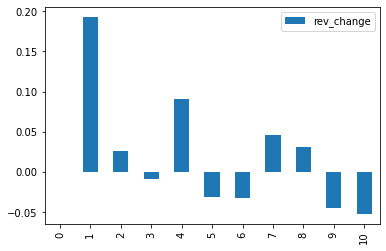

In [14]:
blaze_ca_gmv_change_data[['rev_change']].plot(kind = 'bar')

In [15]:
blaze_ca_gmv_change_data

,year_month,rev_pre_tax_post_discount,count_shop,lag_rev_pre_tax_post_discount,lag_count_shop,rev_per_shop,lag_rev_per_shop,rev_change
0,2021-08-31,50497792.04,235,NaN,NaN,214884.221447,NaN,NaN
1,2021-09-30,63594461.53,248,50497792.04,235.0,256429.280363,214884.221447,0.193337
2,2021-10-31,68648659.92,261,63594461.53,248.0,263021.685517,256429.280363,0.025708
3,2021-11-30,68272899.90,262,68648659.92,261.0,260583.587405,263021.685517,-0.009270
4,2021-12-31,76714104.42,270,68272899.90,262.0,284126.312667,260583.587405,0.090346
5,2022-01-31,73239968.35,266,76714104.42,270.0,275338.226880,284126.312667,-0.030930
6,2022-02-28,70823019.42,266,73239968.35,266.0,266251.952707,275338.226880,-0.033000
7,2022-03-31,76344594.37,274,70823019.42,266.0,278629.906460,266251.952707,0.046490
8,2022-04-30,77274601.90,269,76344594.37,274.0,287266.178067,278629.906460,0.030995
9,2022-05-31,73785464.44,269,77274601.90,269.0,274295.406840,287266.178067,-0.045152


In [16]:
rev_change_bm_with_weight = blaze_ca_gmv_change_data[['year_month','rev_change']]
rev_change_bm_with_weight['weight'] = [numpy.nan,0.28,0.36,0.44,0.52,0.6,0.68,0.76,0.84,0.92,1]
rev_change_bm_with_weight.columns = ['year_month','rev_change_bm','rev_change_weight']
rev_change_bm_with_weight = rev_change_bm_with_weight.reset_index(drop = True)
rev_change_bm_with_weight

,year_month,rev_change_bm,rev_change_weight
0,2021-08-31,NaN,NaN
1,2021-09-30,0.193337,0.28
2,2021-10-31,0.025708,0.36
3,2021-11-30,-0.009270,0.44
4,2021-12-31,0.090346,0.52
5,2022-01-31,-0.030930,0.60
6,2022-02-28,-0.033000,0.68
7,2022-03-31,0.046490,0.76
8,2022-04-30,0.030995,0.84
9,2022-05-31,-0.045152,0.92


In [17]:

blaze_gm_data_long_with_rev  = pd.merge(blaze_gm_data_long,rev_change_bm_with_weight,on=['year_month'], how='inner')
blaze_gm_data_long_with_rev['rev_change_var'] = blaze_gm_data_long_with_rev['rev_change'] - blaze_gm_data_long_with_rev['rev_change_bm']
blaze_gm_data_long_with_rev['rev_change_points'] = [gmv_change_variance_point_mapping(n) for n in blaze_gm_data_long_with_rev['rev_change_var']]
blaze_gm_data_long_with_rev['rev_change_total'] = blaze_gm_data_long_with_rev['rev_change_points'] * blaze_gm_data_long_with_rev['rev_change_weight']



In [18]:
blaze_gm_data_long_with_rev.tail()

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total
2625,2022-06-30,5f3df0a5ef56f908dd5b372c,5f3df0a5ef56f908dd5b3714,37251.43,34910.36,20755.89,16495.54,0.442816,11,62089.86,0.446930,0.450768,0.484744,0.067059,-0.052679,1.0,0.119739,10.0,10.0
2626,2022-06-30,5febae9af6bb2008cd260550,5febae9af6bb2008cd260538,52806.31,56897.51,21523.88,31282.43,0.592399,11,65108.04,0.588868,0.586165,0.570857,-0.071905,-0.052679,1.0,-0.019226,0.0,0.0
2627,2022-06-30,5ed1bde918ccaa08daf3fb9b,5ed1bde918ccaa08daf3fb83,33.94,701.43,1.68,32.26,0.950501,6,170.12,0.835611,0.658414,0.658414,-0.951613,-0.052679,1.0,-0.898934,-5.0,-5.0
2628,2022-06-30,610ab246f799e632f1db7aff,610ab246f799e632f1db7ae6,2796.35,7509.35,1623.39,1172.96,0.419461,11,15900.87,0.282519,0.372454,0.387031,-0.627618,-0.052679,1.0,-0.574938,-5.0,-5.0
2629,2022-06-30,615b2b7629d6d61b3d2ec4ba,615b2b7629d6d61b3d2ec47b,331030.49,321033.26,105279.17,225751.32,0.681965,6,301923.82,0.681589,0.672480,0.672480,0.031141,-0.052679,1.0,0.083820,10.0,10.0


In [19]:

blaze_gm_data_long_with_rev[blaze_gm_data_long_with_rev['shopid'] == '5e7e382298b27008c4b1dd2c']

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total
135,2021-08-31,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1115698.92,NaN,332295.58,783403.34,0.702164,11,332295.58,0.702164,0.702164,0.702164,NaN,NaN,NaN,NaN,NaN,NaN
346,2021-09-30,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1388192.66,1115698.92,411934.97,976257.69,0.703258,11,744230.55,0.702711,0.702711,0.702711,0.244236,0.193337,0.28,0.050899,10.0,2.8
568,2021-10-31,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1435250.95,1388192.66,429648.56,1005602.39,0.700646,11,1173879.11,0.702023,0.702023,0.702023,0.033899,0.025708,0.36,0.008190,5.0,1.8
802,2021-11-30,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1294017.31,1435250.95,428172.10,865845.21,0.669114,11,1269755.63,0.691006,0.693795,0.693795,-0.098403,-0.009270,0.44,-0.089134,-2.5,-1.1
1049,2021-12-31,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1412869.84,1294017.31,444759.64,968110.20,0.685208,11,1302580.30,0.684989,0.692078,0.692078,0.091848,0.090346,0.52,0.001502,5.0,2.6
1304,2022-01-31,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1477630.58,1412869.84,467628.72,1010001.86,0.683528,11,1340560.46,0.679283,0.690653,0.690653,0.045836,-0.030930,0.60,0.076767,10.0,6.0
1561,2022-02-28,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1226724.39,1477630.58,309976.69,916747.70,0.747314,11,1222365.05,0.705350,0.698178,0.698747,-0.169803,-0.033000,0.68,-0.136803,-5.0,-3.4
1815,2022-03-31,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1242103.26,1226724.39,331486.83,910616.43,0.733125,11,1109092.24,0.721322,0.703156,0.703045,0.012537,0.046490,0.76,-0.033953,0.0,0.0
2064,2022-04-30,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,797513.08,1242103.26,334123.00,463390.08,0.581044,11,975586.52,0.687161,0.683222,0.689489,-0.357933,0.030995,0.84,-0.388929,-5.0,-4.2
2308,2022-05-31,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,747521.39,797513.08,317676.75,429844.64,0.575027,11,983286.58,0.629732,0.667541,0.678043,-0.062684,-0.045152,0.92,-0.017532,0.0,0.0


# inventory

In [20]:
blaze_historical_inv = pd.read_sql_query("""
with base as (
    select *,
    --last_day(date) year_month,
    current_quantity * unit_cost total_value
    from blaze_data.inventory
    where  lower(product_category) not like '%sample%'
    and lower(product_category) not like '%display%'
    and lower(product_category) not like '%promo%'
    and lower(product_category) not like '%test%'
    -- EXCLUDE SMALL COGS
    and unit_cost > 0.01
    and current_quantity > 0
    and current_quantity < 1000
   -- and date in ('2022-06-03','2022-06-10','2022-06-17','2022-06-24')

    and state = 'CA'
    and shop_id not in ("5e50449d6c0a910843356fa3",
                        "5e666af1aa809b085a98a646",
                        "56cf846ee38179985229e59e",
                        "5e6d0948b987950831b5092c",
                        "5ab806d6c182bb072e0b0e01",
                        "617b7da0e5cb65322b32781a",
                        "56cf84e4e38179985229e59f",
                        "5ee7c6a938fa9a08c8b7939c",
                        "5eebecd661ea0b08cdbcc386",
                        "56cf855ce38179985229e5a0",
                        "5ef12ad7bb5e7a08c5b3f4f3",
                        "5f1108355ae12008f4fef76e",
                        "5f123a5d12497908d2888dde",
                        "5f2309d579373608c93e6742",
                        "5f341ed02fdd5608e0821b45",
                        "5f8870200260fe08fe708db5",
                        "5f8870200260fe08fe708db6",
                        "5fac6a0b0643cc08efd1d327",
                        "56cf855ce38179985229e5a1",
                        "5d238c1955be2e07f5ee66e5",
                        "57b35a5d920f401e40146301",
                        "603d1a9eb9d7dc08cca27203",
                        "603d1a9eb9d7dc08cca27204",
                        "6046544f61e17808cff96fdb",
                        "6046544f61e17808cff96fdc",
                        "57b35aa8920f401e40146334",
                        "57b6b145920f4045cbe5fe81",
                        "6059219abe32aa08fa3a11dc",
                        "57b6b36a920f4046337f2618",
                        "58a7433f819d9e6ebd427617",
                        "60c0ffd6331cab296f02f49a",
                        "610c0a0d381ba0747c981ce9",
                        "611c0c98127cdd740cff94db",
                        "5a43f72b819d9e3ef9373675",
                        "611c0cc403d2e97dc2c159b0",
                        "5e6d0ac5b987950831b513e3",
                        "5a4563f1819d9e4ae6207e06",
                        "611c0ce7649819050ed4906b",
                        "611c0d02f572ec7882d64eea",
                        "611c0d26d5f1e86542fe3b8b",
                        "61672305b5e382719c7e4c2a",
                        "616dee0e4497e822dae13b21",
                        "616e5b13dd10fe4d3f34fd05",
                        "616e5b13dd10fe4d3f34fd06",
                        "619834e921c8017e23135674",
                        "5ab2d1a5819d9e21137cec3c",
                        "61bb746b82fddc50e058d711",
                        "61c3be757511d81170a29d51",
                        "61d49080eec1b51a3e33dc39",
                        "61d8912bdd71d40c2b68c5b3",
                        "61ba4efb9536472be6a8baa9",
                        "61d895fb3efbfb6da5210ae3",
                        "61d8aaf527205210191d7a1e",
                        "61e72d51073c4a79cfeccb62",
                        "61fdab9eae59d05c49422c3a",
                        "6202bd1c15425361f688aabf",
                        "6202bd1c15425361f688aac0",
                        "5b9f8e1db93307080d35b85f",
                        "5c2c250eabe12808989ac2f7",
                        "58be5603c182bb1f9bcd2ad5",
                        "5c8be64665a6a40808118621",
                        "606761051436a608e166db19",
                        "5ce2eb562d4dcf07fb7d0c5f",
                        "6176fa9eda707b1faba5f717",
                        "5b517867485da70830fcc04e",
                        "5b9f841a17b6e00812fe71f3",
                        "5da023586d8ce1082b9c91bd",
                        "5bbce3db420c21083300e410",
                        "5d238c1955be2e07f5ee66e4",
                        "5b209459062bd807b142a1f6",
                        "5cb1a5839fbb5f0818f6de55",
                        "5cda1adb183d6a0801347027",
                        "5be3903b79015e083194aa70",
                        "5d1ba174cdbd6d0803c99cfd",
                        "5a8a6eb8819d9e78641ab6ec",
                        "5db863825a04a2083b464083",
                        "5d8a7fb3a3274308311743d5",
                        "5d8a7fb3a3274308311743d6",
                        "5d9e425d52d15b0824a8a5d5",
                        "5dd6da52ce4015084c72e8db",
                        "5e07f51837cdd7082662f3c6",
                        "5e4d849981e3cd08326b6c14",
                        "5dfd2308fa462a086a8bfab8",
                        "5e0ee2710a7b7008346b06b4",
                        "5e4d849981e3cd08326b6c15",
                        "5dfd2308fa462a086a8bfab9",
                        "5e6d0adc12f2e208728f9369",
                        "5e6d0948b987950831b5092b",
                        "5ed589d96c0bf408dcc92d97",
                        "5eebecd761ea0b08cdbcc387",
                        "5ef12ad7bb5e7a08c5b3f4f2",
                        "5f63afd430bd7208ce1ab304",
                        "5f63afd430bd7208ce1ab305",
                        "5bf5ce54062bd807e436b473",
                        "5fac691a715f3808cd0aa82d",
                        "5d9d7fc27e2e46081e7e69f3",
                        "6034287d52503608c0b3ca48",
                        "5dfd40ea521ea90860c91848",
                        "6034287d52503608c0b3ca49",
                        "60636227ec491108d1c970d5",
                        "5a9a2274c182bb4ec00a72ca",
                        "60aea3bb1940943cecec2dbf",
                        "60a2f1610f75543c8e7dde50",
                        "5eb98f2d649a6508f87a6436",
                        "5e62a68447d90a086b8231c0",
                        "5e62a68447d90a086b8231c1",
                        "615b634cac08aa0a794158c4",
                        "60a2db8d0f75543c8e7d513b",
                        "60a2db8d0f75543c8e7d513c",
                        "60a4051e67406e7edad8ab88",
                        "60c0ff66082dcc61e42ad4a6",
                        "60c0ff66082dcc61e42ad4a7",
                        "6046c57057abe808d1f260fd",
                        "60636227ec491108d1c970d4",
                        "610abcaec3d09859f9b630d1",
                        "606cfaadba253e08c4189a63",
                        "607a321441cfa308f6e65b58",
                        "6197e31b21c8017e2310c10e",
                        "611d457db7c6f80914292394",
                        "610c0a0d381ba0747c981cea",
                        "610abcaec3d09859f9b630d2",
                        "611c0cb3a29e0f598f108a60",
                        "5fff453a81a63608d3a1a5b7",
                        "615237cc0937e52684b6c134",
                        "620b59c97852ca7a7dcc6f05",
                        "6196aa4deb62c87eba4014ad",
                        "619816781f88a1280f8a0c28",
                        "61d7b217a42c2f124d9b76b1",
                        "61cf4b452bc6657512b92d2a",
                        "61ebb060b04dc7510465f774",
                        "61eedaa0b882812f2f46a23d",
                        "61eedade6716dd2a2e0cfce5",
                        "5e6d0ae6e4a25a0834047467",
                        "5dc3315fe0faca07c6dfe849",
                        "5f7e17594445b008d2f63ebd",
                        "5f7f63053dbcad08cc9edbfb",
                        "5fff453a81a63608d3a1a5b8",
                        "603d5425a9ca7208f886d156",
                        "60e48dbbd5596d7c8a1d24dc",
                        "611c0d335901162ff90ef4dd",
                        "613f771aa96c863c00c1517d",
                        "6153b70fd343dc6230c4b67d",
                        "61699cdf032e1c1f920ec70f",
                        "61699cdf032e1c1f920ec710",
                        "61a7b4c6c8c7d85ea1846f14",
                        "61c390cfb863cb3baddb70f4",
                        "61d7b252ae999342ac05499e",
                        "61e6f857c5da34762f1c1fb5",
                        "61ebb00a335a531542342a32",
                        "620b59c97852ca7a7dcc6f04",
                         "6226640755810d3311e8ecd0")
),
weekly_inv as (
    select date,
           shop_id          shopid,
           company_id       companyid,
           sum(total_value) inventory
    from base
    group by 1, 2, 3
    order by 2, 3, 1
)
select
last_day(date) year_month,
shopid,
companyid,
avg(inventory) inventory

from weekly_inv
group by 1,2,3
""",engine)

In [21]:
blaze_historical_inv['year_month'] = pd.to_datetime(blaze_historical_inv['year_month'])

In [23]:
set(blaze_gm_data_long_with_rev[blaze_gm_data_long_with_rev['year_month'] == '2022-06-30']['shopid']) - set(blaze_historical_inv['shopid'])



set()

# joined

In [26]:
data_joined = pd.merge(blaze_gm_data_long_with_rev,blaze_historical_inv,on=['year_month','shopid','companyid'], how='inner')



In [32]:
#data_joined[data_joined['shopid'] == '5e7e382298b27008c4b1dd2c']

In [28]:
data_joined['inventory_turnover'] = data_joined['sum_cogs_3m'] / data_joined['inventory'] * 4
data_joined['year_month'] = pd.to_datetime(data_joined['year_month'])

In [29]:
data_joined[['year_month','shopid']].groupby(['year_month']).nunique()

,shopid
year_month,
2021-08-31,204
2021-09-30,213
2021-10-31,223
2021-11-30,237
2021-12-31,247
2022-01-31,259
2022-02-28,255
2022-03-31,253
2022-04-30,249


In [30]:
data_joined[data_joined['year_month'] >= '2021-10-31'].groupby(['year_month'])['inventory_turnover'].describe().reset_index()

,year_month,count,mean,std,min,25%,50%,75%,max
0,2021-10-31,223.0,8.996378,7.054265,0.003011,3.846721,7.608396,12.639869,40.262760
1,2021-11-30,237.0,9.198414,7.499872,0.008819,3.863265,7.704033,13.024884,46.072751
2,2021-12-31,247.0,8.951504,7.094430,0.001594,3.822878,7.922653,12.119256,46.696839
3,2022-01-31,259.0,8.546106,6.484956,0.003991,3.533744,7.575142,11.561226,41.555538
4,2022-02-28,255.0,8.928575,7.114264,0.003359,4.010165,7.804618,11.586438,60.605042
5,2022-03-31,253.0,8.845122,6.785199,0.004948,4.415758,7.875546,11.319975,57.943536
6,2022-04-30,249.0,8.684667,8.533374,0.005322,4.435339,7.399148,10.612418,108.747541
7,2022-05-31,244.0,9.485294,6.828028,0.006116,4.646452,8.370260,12.648227,41.199064
8,2022-06-30,242.0,9.676425,6.503310,0.005039,5.012488,8.468116,13.177583,33.244051


In [31]:
round(data_joined['inventory_turnover'].quantile(0.95),2)

20.95

# Vendor Churn

In [46]:
blaze_vc_data = pd.read_sql_query("""
-- purcase order data
with date as (
    SELECT last_day(year_month) year_month_all
FROM UNNEST(
    GENERATE_DATE_ARRAY(DATE('2021-08-01'), CURRENT_DATE(), INTERVAL 1 month)
) AS year_month
),
vendor as (
    select distinct vendor_id from blaze_data.purchase_orders
),
shop as (
    select distinct shop_id from blaze_data.purchase_orders
    where state = 'CA'
    and purchase_order_status = 'Closed'
    and shop_id not in ("5e50449d6c0a910843356fa3",
                        "5e666af1aa809b085a98a646",
                        "56cf846ee38179985229e59e",
                        "5e6d0948b987950831b5092c",
                        "5ab806d6c182bb072e0b0e01",
                        "617b7da0e5cb65322b32781a",
                        "56cf84e4e38179985229e59f",
                        "5ee7c6a938fa9a08c8b7939c",
                        "5eebecd661ea0b08cdbcc386",
                        "56cf855ce38179985229e5a0",
                        "5ef12ad7bb5e7a08c5b3f4f3",
                        "5f1108355ae12008f4fef76e",
                        "5f123a5d12497908d2888dde",
                        "5f2309d579373608c93e6742",
                        "5f341ed02fdd5608e0821b45",
                        "5f8870200260fe08fe708db5",
                        "5f8870200260fe08fe708db6",
                        "5fac6a0b0643cc08efd1d327",
                        "56cf855ce38179985229e5a1",
                        "5d238c1955be2e07f5ee66e5",
                        "57b35a5d920f401e40146301",
                        "603d1a9eb9d7dc08cca27203",
                        "603d1a9eb9d7dc08cca27204",
                        "6046544f61e17808cff96fdb",
                        "6046544f61e17808cff96fdc",
                        "57b35aa8920f401e40146334",
                        "57b6b145920f4045cbe5fe81",
                        "6059219abe32aa08fa3a11dc",
                        "57b6b36a920f4046337f2618",
                        "58a7433f819d9e6ebd427617",
                        "60c0ffd6331cab296f02f49a",
                        "610c0a0d381ba0747c981ce9",
                        "611c0c98127cdd740cff94db",
                        "5a43f72b819d9e3ef9373675",
                        "611c0cc403d2e97dc2c159b0",
                        "5e6d0ac5b987950831b513e3",
                        "5a4563f1819d9e4ae6207e06",
                        "611c0ce7649819050ed4906b",
                        "611c0d02f572ec7882d64eea",
                        "611c0d26d5f1e86542fe3b8b",
                        "61672305b5e382719c7e4c2a",
                        "616dee0e4497e822dae13b21",
                        "616e5b13dd10fe4d3f34fd05",
                        "616e5b13dd10fe4d3f34fd06",
                        "619834e921c8017e23135674",
                        "5ab2d1a5819d9e21137cec3c",
                        "61bb746b82fddc50e058d711",
                        "61c3be757511d81170a29d51",
                        "61d49080eec1b51a3e33dc39",
                        "61d8912bdd71d40c2b68c5b3",
                        "61ba4efb9536472be6a8baa9",
                        "61d895fb3efbfb6da5210ae3",
                        "61d8aaf527205210191d7a1e",
                        "61e72d51073c4a79cfeccb62",
                        "61fdab9eae59d05c49422c3a",
                        "6202bd1c15425361f688aabf",
                        "6202bd1c15425361f688aac0",
                        "5b9f8e1db93307080d35b85f",
                        "5c2c250eabe12808989ac2f7",
                        "58be5603c182bb1f9bcd2ad5",
                        "5c8be64665a6a40808118621",
                        "606761051436a608e166db19",
                        "5ce2eb562d4dcf07fb7d0c5f",
                        "6176fa9eda707b1faba5f717",
                        "5b517867485da70830fcc04e",
                        "5b9f841a17b6e00812fe71f3",
                        "5da023586d8ce1082b9c91bd",
                        "5bbce3db420c21083300e410",
                        "5d238c1955be2e07f5ee66e4",
                        "5b209459062bd807b142a1f6",
                        "5cb1a5839fbb5f0818f6de55",
                        "5cda1adb183d6a0801347027",
                        "5be3903b79015e083194aa70",
                        "5d1ba174cdbd6d0803c99cfd",
                        "5a8a6eb8819d9e78641ab6ec",
                        "5db863825a04a2083b464083",
                        "5d8a7fb3a3274308311743d5",
                        "5d8a7fb3a3274308311743d6",
                        "5d9e425d52d15b0824a8a5d5",
                        "5dd6da52ce4015084c72e8db",
                        "5e07f51837cdd7082662f3c6",
                        "5e4d849981e3cd08326b6c14",
                        "5dfd2308fa462a086a8bfab8",
                        "5e0ee2710a7b7008346b06b4",
                        "5e4d849981e3cd08326b6c15",
                        "5dfd2308fa462a086a8bfab9",
                        "5e6d0adc12f2e208728f9369",
                        "5e6d0948b987950831b5092b",
                        "5ed589d96c0bf408dcc92d97",
                        "5eebecd761ea0b08cdbcc387",
                        "5ef12ad7bb5e7a08c5b3f4f2",
                        "5f63afd430bd7208ce1ab304",
                        "5f63afd430bd7208ce1ab305",
                        "5bf5ce54062bd807e436b473",
                        "5fac691a715f3808cd0aa82d",
                        "5d9d7fc27e2e46081e7e69f3",
                        "6034287d52503608c0b3ca48",
                        "5dfd40ea521ea90860c91848",
                        "6034287d52503608c0b3ca49",
                        "60636227ec491108d1c970d5",
                        "5a9a2274c182bb4ec00a72ca",
                        "60aea3bb1940943cecec2dbf",
                        "60a2f1610f75543c8e7dde50",
                        "5eb98f2d649a6508f87a6436",
                        "5e62a68447d90a086b8231c0",
                        "5e62a68447d90a086b8231c1",
                        "615b634cac08aa0a794158c4",
                        "60a2db8d0f75543c8e7d513b",
                        "60a2db8d0f75543c8e7d513c",
                        "60a4051e67406e7edad8ab88",
                        "60c0ff66082dcc61e42ad4a6",
                        "60c0ff66082dcc61e42ad4a7",
                        "6046c57057abe808d1f260fd",
                        "60636227ec491108d1c970d4",
                        "610abcaec3d09859f9b630d1",
                        "606cfaadba253e08c4189a63",
                        "607a321441cfa308f6e65b58",
                        "6197e31b21c8017e2310c10e",
                        "611d457db7c6f80914292394",
                        "610c0a0d381ba0747c981cea",
                        "610abcaec3d09859f9b630d2",
                        "611c0cb3a29e0f598f108a60",
                        "5fff453a81a63608d3a1a5b7",
                        "615237cc0937e52684b6c134",
                        "620b59c97852ca7a7dcc6f05",
                        "6196aa4deb62c87eba4014ad",
                        "619816781f88a1280f8a0c28",
                        "61d7b217a42c2f124d9b76b1",
                        "61cf4b452bc6657512b92d2a",
                        "61ebb060b04dc7510465f774",
                        "61eedaa0b882812f2f46a23d",
                        "61eedade6716dd2a2e0cfce5",
                        "5e6d0ae6e4a25a0834047467",
                        "5dc3315fe0faca07c6dfe849",
                        "5f7e17594445b008d2f63ebd",
                        "5f7f63053dbcad08cc9edbfb",
                        "5fff453a81a63608d3a1a5b8",
                        "603d5425a9ca7208f886d156",
                        "60e48dbbd5596d7c8a1d24dc",
                        "611c0d335901162ff90ef4dd",
                        "613f771aa96c863c00c1517d",
                        "6153b70fd343dc6230c4b67d",
                        "61699cdf032e1c1f920ec70f",
                        "61699cdf032e1c1f920ec710",
                        "61a7b4c6c8c7d85ea1846f14",
                        "61c390cfb863cb3baddb70f4",
                        "61d7b252ae999342ac05499e",
                        "61e6f857c5da34762f1c1fb5",
                        "61ebb00a335a531542342a32",
                        "620b59c97852ca7a7dcc6f04",
                         "6226640755810d3311e8ecd0")
),
all_data as (
    with sub as (
        select *
        from date
                 cross join vendor
    )
    select * from sub cross join shop
),
po_clean as (select *
from  (
select DATE_DIFF(week_end, week_start, DAY) diff,* from blaze_data.purchase_orders
             WHERE not (week_start = '2022-01-29' and week_end = '2022-02-05')
and not (week_start = '2022-02-26' and week_end = '2022-03-05')
and not (week_start = '2022-03-27' and week_end = '2022-04-03'))
     where diff < 10)
     ,
po_data as (
    select last_day(week_start) year_month,
           shop_id,
           vendor_id,
           sum(total_cost)      total_amount

    from po_clean
    group by 1, 2, 3
),

vc_data as (
    select all_data.year_month_all,
           all_data.vendor_id,
           all_data.shop_id,
           COALESCE(po_data.total_amount, 0) amount,
           sum(po_data.total_amount) over (partition by all_data.shop_id,all_data.vendor_id) facility_total,
           sum(po_data.total_amount) over (partition by all_data.shop_id) all_vendor_total,
           sum(po_data.total_amount) over (partition by all_data.shop_id,all_data.vendor_id order by all_data.year_month_all rows between 3 preceding and current row) last_4m_total
           --lag( COALESCE(po_data.total_amount,0)) over (partition by all_data.vendor_id,all_data.shop_id order by year_month_all) lag_total_amount,

    from all_data
             left join po_data
                       on all_data.year_month_all = po_data.year_month
                           and all_data.vendor_id = po_data.vendor_id
                           and all_data.shop_id = po_data.shop_id
),

vc_data_weight as (
    select year_month_all,
           vendor_id,
           shop_id,
           amount,
           COALESCE(facility_total, 0)  vendor_total,
           COALESCE(all_vendor_total, 0) all_vendor_total,
           COALESCE(last_4m_total, 0) last_4m_total
    from vc_data
),
vc_data_weight_clean as (
    select
    year_month_all,
    vendor_id,
    shop_id,
    amount,
    vendor_total,
    all_vendor_total,
    last_4m_total,
    vendor_total / NULLIF(all_vendor_total, 0)  vendor_perc,
    case when last_4m_total = 0 then '4m_inactive' else '4m_active' end as activity,
    case
    when  vendor_total/ NULLIF(all_vendor_total, 0) > 0.001 then 'significant'
    else 'non-significant' end as significance
    from vc_data_weight
),
/* for debug
     select * from vc_data_weight_clean
                where shop_id = '5f0d3e91aa5bca08d2438446'
                and significance = 'significant'

 */

vc_final as (
    select
    *,
    case when activity = '4m_active' and significance = 'significant' then 'active'
    else (case when significance = 'significant' then 'inactive' else 'exclude' end) end as measure
    from vc_data_weight_clean
    )


select
year_month_all,
shop_id shopid,
sum(vendor_perc) total_vc
from vc_final
where measure = 'inactive'
group by 1,2

""",engine)

In [50]:
blaze_vc_data['year_month_all'] = pd.to_datetime(blaze_vc_data['year_month_all'])
blaze_vc_data[blaze_vc_data['shopid'] == '5e7e382298b27008c4b1dd2c']

,year_month_all,shopid,total_vc
25,2022-04-30,5e7e382298b27008c4b1dd2c,1.000000
922,2021-11-30,5e7e382298b27008c4b1dd2c,0.055881
965,2022-03-31,5e7e382298b27008c4b1dd2c,0.036233
1272,2022-05-31,5e7e382298b27008c4b1dd2c,1.000000
1916,2021-08-31,5e7e382298b27008c4b1dd2c,1.000000
1917,2022-06-30,5e7e382298b27008c4b1dd2c,1.000000
2396,2022-07-31,5e7e382298b27008c4b1dd2c,1.000000
2563,2021-09-30,5e7e382298b27008c4b1dd2c,1.000000
2564,2021-10-31,5e7e382298b27008c4b1dd2c,1.000000


In [48]:
data_joined.head()

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory,inventory_turnover
0,2021-08-31,5c7e8c7b722ed607e61edb1d,5c7e8c7b722ed607e61edb06,65660.48,NaN,31627.23,34033.25,0.518322,11,31627.23,0.518322,0.518322,0.518322,NaN,NaN,NaN,NaN,NaN,NaN,40917.631667,3.091795
1,2021-08-31,5dae02faed12be0829c3d21d,5c422367062bd807e98fc5dc,1422.48,NaN,584.26,838.22,0.589267,11,584.26,0.589267,0.589267,0.589267,NaN,NaN,NaN,NaN,NaN,NaN,1962.125000,1.191076
2,2021-08-31,5e3dfbbc2e0bdd083356f416,5e3dfbbc2e0bdd083356f3fe,19807.77,NaN,11310.46,8497.31,0.428989,10,11310.46,0.428989,0.428989,0.428989,NaN,NaN,NaN,NaN,NaN,NaN,34686.692083,1.304300
3,2021-08-31,5fd90ebbd68f6608d3f9ed29,5fd90ebbd68f6608d3f9ed11,165397.52,NaN,83161.40,82236.12,0.497203,11,83161.40,0.497203,0.497203,0.497203,NaN,NaN,NaN,NaN,NaN,NaN,244708.998958,1.359352
4,2021-08-31,5c422367062bd807e98fc5f3,5c422367062bd807e98fc5dc,48760.41,NaN,16247.90,32512.51,0.666781,11,16247.90,0.666781,0.666781,0.666781,NaN,NaN,NaN,NaN,NaN,NaN,12862.633750,5.052744


In [56]:
data_joined_with_vc = data_joined.merge(blaze_vc_data,left_on =['shopid','year_month'], right_on = ['shopid','year_month_all'],how = 'left')

In [58]:
data_joined_with_vc[data_joined_with_vc['shopid'] == '5e7e382298b27008c4b1dd2c']

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory,inventory_turnover,year_month_all,total_vc
135,2021-08-31,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1115698.92,NaN,332295.58,783403.34,0.702164,11,332295.58,0.702164,0.702164,0.702164,NaN,NaN,NaN,NaN,NaN,NaN,290612.997034,4.573719,2021-08-31,1.000000
345,2021-09-30,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1388192.66,1115698.92,411934.97,976257.69,0.703258,11,744230.55,0.702711,0.702711,0.702711,0.244236,0.193337,0.28,0.050899,10.0,2.8,269526.969097,11.044988,2021-09-30,1.000000
567,2021-10-31,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1435250.95,1388192.66,429648.56,1005602.39,0.700646,11,1173879.11,0.702023,0.702023,0.702023,0.033899,0.025708,0.36,0.008190,5.0,1.8,242812.265011,19.338053,2021-10-31,1.000000
801,2021-11-30,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1294017.31,1435250.95,428172.10,865845.21,0.669114,11,1269755.63,0.691006,0.693795,0.693795,-0.098403,-0.009270,0.44,-0.089134,-2.5,-1.1,240289.071098,21.137135,2021-11-30,0.055881
1045,2021-12-31,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1412869.84,1294017.31,444759.64,968110.20,0.685208,11,1302580.30,0.684989,0.692078,0.692078,0.091848,0.090346,0.52,0.001502,5.0,2.6,520843.397147,10.003623,NaT,NaN
1300,2022-01-31,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1477630.58,1412869.84,467628.72,1010001.86,0.683528,11,1340560.46,0.679283,0.690653,0.690653,0.045836,-0.030930,0.60,0.076767,10.0,6.0,306688.148778,17.484346,NaT,NaN
1557,2022-02-28,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1226724.39,1477630.58,309976.69,916747.70,0.747314,11,1222365.05,0.705350,0.698178,0.698747,-0.169803,-0.033000,0.68,-0.136803,-5.0,-3.4,333825.682778,14.646747,NaT,NaN
1811,2022-03-31,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1242103.26,1226724.39,331486.83,910616.43,0.733125,11,1109092.24,0.721322,0.703156,0.703045,0.012537,0.046490,0.76,-0.033953,0.0,0.0,297775.181111,14.898384,2022-03-31,0.036233
2060,2022-04-30,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,797513.08,1242103.26,334123.00,463390.08,0.581044,11,975586.52,0.687161,0.683222,0.689489,-0.357933,0.030995,0.84,-0.388929,-5.0,-4.2,249973.916725,15.611013,2022-04-30,1.000000
2304,2022-05-31,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,747521.39,797513.08,317676.75,429844.64,0.575027,11,983286.58,0.629732,0.667541,0.678043,-0.062684,-0.045152,0.92,-0.017532,0.0,0.0,272247.995333,14.446925,2022-05-31,1.000000


# UW

In [ ]:
recent = data_joined_with_vc[data_joined_with_vc['year_month'] == '2022-06-30']
recent = recent.reset_index(drop = True)

In [ ]:
recent[['year_month','shopid']].groupby(['year_month']).nunique()

## gm % score

In [59]:
def get_gm_perc_scores(threshold,gm_3,gm_6,gm_all):
    # 3m score
    if gm_3 <= threshold[0][0]:
        score_3m = -2
    elif threshold[0][0] < gm_3 <= threshold[0][1]:
        score_3m = 0
    elif threshold[0][1] < gm_3 <= threshold[0][2]:
        score_3m = 5
    elif threshold[0][2] < gm_3 <= threshold[0][3]:
        score_3m = 5
    else:
        score_3m = 0
    # 6m score
    if gm_6 <= threshold[1][0]:
        score_6m = -2
    elif threshold[1][0] < gm_6 <= threshold[1][1]:
        score_6m = 0
    elif threshold[1][1] < gm_6 <= threshold[1][2]:
        score_6m = 5
    elif threshold[1][2] < gm_6 <= threshold[1][3]:
        score_6m = 5
    else:
        score_6m = 0
    # all time score
    if gm_all <= threshold[2][0]:
        score_all = -2
    elif threshold[2][0] < gm_all <= threshold[2][1]:
        score_all = 0
    elif threshold[2][1] < gm_all <= threshold[2][2]:
        score_all = 5
    elif threshold[2][2] < gm_all <= threshold[2][3]:
        score_all = 5
    else:
        score_all = 0
    return score_3m,score_6m,score_all
    

In [ ]:
#gm_threshold = [[0.47,0.53,0.59,0.7],[0.47,0.53,0.59,0.7],[0.47,0.53,0.59,0.7]]

In [ ]:
#gm_threshold = [[0.46,0.52,0.58,0.7],[0.46,0.52,0.58,0.7],[0.46,0.52,0.58,0.7]]

In [ ]:
#gm_threshold = [[0.45,0.51,0.57,0.7],[0.45,0.51,0.57,0.7],[0.45,0.51,0.57,0.7]]

In [60]:
gm_threshold = [[0.44,0.50,0.56,0.7],[0.44,0.50,0.56,0.7],[0.44,0.50,0.56,0.7]]

In [61]:
gm_score_data = data_joined_with_vc.apply(lambda row: get_gm_perc_scores(gm_threshold,row['avg_margin_3m'],row['avg_margin_6m'],row['avg_margin_all']),axis = 1)
recent_with_gm = pd.concat([data_joined_with_vc, pd.DataFrame([list(y) for y in gm_score_data.values], columns = ['gm_3m_score', 'gm_6m_score','gm_all_score'])],axis=1)



In [62]:
recent_with_gm

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory,inventory_turnover,year_month_all,total_vc,gm_3m_score,gm_6m_score,gm_all_score
0,2021-08-31,5c7e8c7b722ed607e61edb1d,5c7e8c7b722ed607e61edb06,65660.48,NaN,31627.23,34033.25,0.518322,11,31627.23,0.518322,0.518322,0.518322,NaN,NaN,NaN,NaN,NaN,NaN,40917.631667,3.091795,2021-08-31,0.149868,5,5,5
1,2021-08-31,5dae02faed12be0829c3d21d,5c422367062bd807e98fc5dc,1422.48,NaN,584.26,838.22,0.589267,11,584.26,0.589267,0.589267,0.589267,NaN,NaN,NaN,NaN,NaN,NaN,1962.125000,1.191076,NaT,NaN,5,5,5
2,2021-08-31,5e3dfbbc2e0bdd083356f416,5e3dfbbc2e0bdd083356f3fe,19807.77,NaN,11310.46,8497.31,0.428989,10,11310.46,0.428989,0.428989,0.428989,NaN,NaN,NaN,NaN,NaN,NaN,34686.692083,1.304300,2021-08-31,0.592509,-2,-2,-2
3,2021-08-31,5fd90ebbd68f6608d3f9ed29,5fd90ebbd68f6608d3f9ed11,165397.52,NaN,83161.40,82236.12,0.497203,11,83161.40,0.497203,0.497203,0.497203,NaN,NaN,NaN,NaN,NaN,NaN,244708.998958,1.359352,2021-08-31,0.280231,0,0,0
4,2021-08-31,5c422367062bd807e98fc5f3,5c422367062bd807e98fc5dc,48760.41,NaN,16247.90,32512.51,0.666781,11,16247.90,0.666781,0.666781,0.666781,NaN,NaN,NaN,NaN,NaN,NaN,12862.633750,5.052744,2021-08-31,0.614180,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2621,2022-06-30,5f3df0a5ef56f908dd5b372c,5f3df0a5ef56f908dd5b3714,37251.43,34910.36,20755.89,16495.54,0.442816,11,62089.86,0.446930,0.450768,0.484744,0.067059,-0.052679,1.0,0.119739,10.0,10.0,49736.585000,4.993496,2022-06-30,0.063098,0,0,0
2622,2022-06-30,5febae9af6bb2008cd260550,5febae9af6bb2008cd260538,52806.31,56897.51,21523.88,31282.43,0.592399,11,65108.04,0.588868,0.586165,0.570857,-0.071905,-0.052679,1.0,-0.019226,0.0,0.0,19792.383250,13.158201,2022-06-30,0.052878,5,5,5
2623,2022-06-30,5ed1bde918ccaa08daf3fb9b,5ed1bde918ccaa08daf3fb83,33.94,701.43,1.68,32.26,0.950501,6,170.12,0.835611,0.658414,0.658414,-0.951613,-0.052679,1.0,-0.898934,-5.0,-5.0,2338.395000,0.291003,NaT,NaN,0,5,5
2624,2022-06-30,610ab246f799e632f1db7aff,610ab246f799e632f1db7ae6,2796.35,7509.35,1623.39,1172.96,0.419461,11,15900.87,0.282519,0.372454,0.387031,-0.627618,-0.052679,1.0,-0.574938,-5.0,-5.0,48945.808333,1.299467,2022-06-30,1.000000,-2,-2,-2


## inventory turnover score

In [63]:
recent_with_gm['turnover_score'] = [10 if (recent_with_gm['inventory_turnover'][i] >= 6 and recent_with_gm['inventory_turnover'][i] <= 26) else 0 for i in range(len(recent_with_gm))]



In [65]:
recent_with_gm[recent_with_gm['shopid'] == '5e7e382298b27008c4b1dd2c']

,year_month,shopid,companyid,rev_pre_tax_post_discount,lag_rev_pre_tax_post_discount,cogs,profit_pre_tax_post_discount,margin_pre_tax_post_discount,month_available,sum_cogs_3m,avg_margin_3m,avg_margin_6m,avg_margin_all,rev_change,rev_change_bm,rev_change_weight,rev_change_var,rev_change_points,rev_change_total,inventory,inventory_turnover,year_month_all,total_vc,gm_3m_score,gm_6m_score,gm_all_score,turnover_score
135,2021-08-31,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1115698.92,NaN,332295.58,783403.34,0.702164,11,332295.58,0.702164,0.702164,0.702164,NaN,NaN,NaN,NaN,NaN,NaN,290612.997034,4.573719,2021-08-31,1.000000,0,0,0,0
345,2021-09-30,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1388192.66,1115698.92,411934.97,976257.69,0.703258,11,744230.55,0.702711,0.702711,0.702711,0.244236,0.193337,0.28,0.050899,10.0,2.8,269526.969097,11.044988,2021-09-30,1.000000,0,0,0,10
567,2021-10-31,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1435250.95,1388192.66,429648.56,1005602.39,0.700646,11,1173879.11,0.702023,0.702023,0.702023,0.033899,0.025708,0.36,0.008190,5.0,1.8,242812.265011,19.338053,2021-10-31,1.000000,0,0,0,10
801,2021-11-30,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1294017.31,1435250.95,428172.10,865845.21,0.669114,11,1269755.63,0.691006,0.693795,0.693795,-0.098403,-0.009270,0.44,-0.089134,-2.5,-1.1,240289.071098,21.137135,2021-11-30,0.055881,5,5,5,10
1045,2021-12-31,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1412869.84,1294017.31,444759.64,968110.20,0.685208,11,1302580.30,0.684989,0.692078,0.692078,0.091848,0.090346,0.52,0.001502,5.0,2.6,520843.397147,10.003623,NaT,NaN,5,5,5,10
1300,2022-01-31,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1477630.58,1412869.84,467628.72,1010001.86,0.683528,11,1340560.46,0.679283,0.690653,0.690653,0.045836,-0.030930,0.60,0.076767,10.0,6.0,306688.148778,17.484346,NaT,NaN,5,5,5,10
1557,2022-02-28,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1226724.39,1477630.58,309976.69,916747.70,0.747314,11,1222365.05,0.705350,0.698178,0.698747,-0.169803,-0.033000,0.68,-0.136803,-5.0,-3.4,333825.682778,14.646747,NaT,NaN,0,5,5,10
1811,2022-03-31,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,1242103.26,1226724.39,331486.83,910616.43,0.733125,11,1109092.24,0.721322,0.703156,0.703045,0.012537,0.046490,0.76,-0.033953,0.0,0.0,297775.181111,14.898384,2022-03-31,0.036233,0,0,0,10
2060,2022-04-30,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,797513.08,1242103.26,334123.00,463390.08,0.581044,11,975586.52,0.687161,0.683222,0.689489,-0.357933,0.030995,0.84,-0.388929,-5.0,-4.2,249973.916725,15.611013,2022-04-30,1.000000,5,5,5,10
2304,2022-05-31,5e7e382298b27008c4b1dd2c,5e7e382298b27008c4b1dd14,747521.39,797513.08,317676.75,429844.64,0.575027,11,983286.58,0.629732,0.667541,0.678043,-0.062684,-0.045152,0.92,-0.017532,0.0,0.0,272247.995333,14.446925,2022-05-31,1.000000,5,5,5,10


## rev change score

In [ ]:
rev_change_score = blaze_gm_data_long_with_rev[['shopid','rev_change_total']].groupby('shopid').sum().reset_index()

In [ ]:
rev_change_score['rev_change_score'] = [max(min(round(rev_change_score['rev_change_total'][i],2),10),-10) for i in range(len(rev_change_score))]
rev_change_score.sort_values(by = 'rev_change_total')


## gm $ score

In [ ]:
gm_dollar_score = blaze_gm_data_long_with_rev[['shopid','profit_pre_tax_post_discount']].groupby('shopid').mean().reset_index()

In [ ]:
gm_dollar_score['gm_dollar_score'] = [15 if gm_dollar_score['profit_pre_tax_post_discount'][i] >= 200000 else 0 for i in range(len(rev_change_score))]



In [ ]:
recent_with_gm_and_rev_change = pd.merge(recent_with_gm,rev_change_score[['shopid','rev_change_score']],on=['shopid'], how='inner')
recent_with_gm_and_rev_change

# VC score

In [ ]:
recent_with_gm_and_rev_change['vc_score'] = [10 if recent_with_gm_and_rev_change['total_vc'][i] < 0.17 else 0 for i in range(len(recent_with_gm_and_rev_change))]



# Final

In [ ]:
final = pd.merge(recent_with_gm_and_rev_change,gm_dollar_score[['shopid','gm_dollar_score']],on=['shopid'], how='inner')



In [ ]:
final['total_gm_perc_score'] = final['gm_3m_score'] + final['gm_6m_score'] + final['gm_all_score']
final['total_gm_score'] = [min(final['gm_dollar_score'][i]+final['total_gm_perc_score'][i],15) for i in range(len(final))]
final['total_score'] = final['total_gm_score'] + final['rev_change_score'] + final['turnover_score'] + final['vc_score']
final['credit_limit'] = [round(min(final['sum_cogs_3m'][i],final['inventory'][i]),0) for i in range(len(final))]
                        



In [ ]:
# final['total_gm_perc_score'] = final['gm_3m_score'] + final['gm_6m_score'] + final['gm_all_score']
# final['total_gm_score'] = [min(final['gm_dollar_score'][i]+final['total_gm_perc_score'][i],15) for i in range(len(final))]
# final['total_score'] = final['total_gm_score'] + final['rev_change_score'] + final['turnover_score'] 
# final['credit_limit'] = [round(min(final['sum_cogs_3m'][i],final['inventory'][i]),0) for i in range(len(final))]
                        



In [ ]:
final['total_score'].describe()

In [ ]:
final['shopid'].nunique()

In [ ]:
#final.to_csv('blaze_ca_july_all.csv')

In [ ]:
pass_list = final[final['total_score'] >= 30]

In [ ]:
final_pass = pass_list[(pass_list['profit_pre_tax_post_discount'] >= 25000) & (pass_list['credit_limit'] >= 30000)]
final_pass = final_pass.reset_index(drop = True)

In [ ]:
final_pass['credit_limit_final'] = [min(max(final_pass['credit_limit'][i],50000),250000) for i in range(len(final_pass))]

In [ ]:
def calculate_interest_rate(score, full_score):
    score_ratio = score / full_score
    placeholder = (1 + 0.5 * (1 - score_ratio)) * 0.015
    rate = placeholder * 12
    return round(placeholder, 4), round(rate, 4)

In [ ]:
final_pass['annual_rate'] = [calculate_interest_rate(final_pass['total_score'][i],45)[1] for i in range(len(final_pass))]
final_pass['monthly_rate'] = [calculate_interest_rate(final_pass['total_score'][i],45)[0] for i in range(len(final_pass))]



In [ ]:
final_pass.shape[0] / final.shape[0]

# Analysis

## final

In [ ]:
final_pass.head()

In [ ]:
final[['gm_3m_score','shopid']].groupby('gm_3m_score').count() / final.shape[0]

In [ ]:
final[['gm_6m_score','shopid']].groupby('gm_6m_score').count() / final.shape[0]

In [ ]:
final[['gm_all_score','shopid']].groupby('gm_all_score').count() / final.shape[0]

In [ ]:
final[['turnover_score','shopid']].groupby('turnover_score').count() / final.shape[0]

In [ ]:
final[['vc_score','shopid']].groupby('vc_score').count() / final.shape[0]


In [ ]:

final[['gm_dollar_score','shopid']].groupby('gm_dollar_score').count() / final.shape[0]


## final pass

In [ ]:
final_pass[['gm_3m_score','shopid']].groupby('gm_3m_score').count() / final_pass.shape[0]

In [ ]:
final_pass[['gm_6m_score','shopid']].groupby('gm_6m_score').count() / final_pass.shape[0]

In [ ]:
final_pass[['gm_all_score','shopid']].groupby('gm_all_score').count() / final_pass.shape[0]

In [ ]:
final_pass[['turnover_score','shopid']].groupby('turnover_score').count() / final_pass.shape[0]

In [ ]:
final_pass[['vc_score','shopid']].groupby('vc_score').count() / final_pass.shape[0]

In [ ]:
final_pass[['gm_dollar_score','shopid']].groupby('gm_dollar_score').count() / final_pass.shape[0]

In [ ]:
#final_pass.to_csv('blaze_ca_july.csv')